# Analytical model of the WFIRST IFS

This is an analytical model to construct a simple SNR of a given spectrum.

In [1]:
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure', titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.
from astropy.io import fits
import astropy.units as u
import astropy.constants as c
import pandas as pd
import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('main')
import os
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST/')
from params import Params
par = Params()
par.hdr
from scipy.interpolate import interp1d
import pandas as pd
from astropy.table import Table, QTable
from crispy.tools.detutils import frebin
from scipy import ndimage
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


In [2]:
def IFSModel(datafile,
             minlam=700*u.nm,
             maxlam=841*u.nm,
             Vmag=4.83,
             R=50,
             QEfile=None,
             QELosses=0.9*0.97*0.9*0.78,  # losses on top of QE
             verbose=True,
             cic=2e-2*u.ct,  # CIC
             dark=2.24e-4*u.ct/u.s,  # dark current
             zodi=7.6e-4*u.ct/u.s,  # total zodiacal contribution
             CFcontrast=2.6e-9,
             I_pk=1.4e-3,
             mpix=24,  # Noise equivalent pixels
             nbins=None,
             cgi_mpix=32,  # used for speckle estimates (will ask Bijan)
             sp_tau=0.34,  # speckle throughput
             tau=0.0116,  # planet throughput
             A=3.68*u.m**2,  # aperture size
             mult=1.32,
             fpp=0.1,  # post-processing factor
             obstime=100*3600*u.s,  # observation time
             ftime=100*u.s,  # frame exposure time
             forceSNR=None,  # 10,
             ntrials=1000,
             ):
    # load QE
    loadQE = np.loadtxt(QEfile)
    QE = interp1d(loadQE[:, 0]/1000, loadQE[:, 1])

    # Load Sergi's table
    table = pd.read_table(datafile,
                          names=('wavelength', 'albedo',
                                 'contrast', 'star', 'flux'),
                          delimiter=',')
    if verbose:
        plt.figure()
        plt.plot(table['wavelength'], table['albedo'])
        plt.title('Albedo')
        plt.xlabel('Wavelength  (um)')
        plt.ylabel('Albedo')

    # load stellar spectra
    fname = par.codeRoot+'/Inputs/ETC/Spectra.csv'
    st = pd.read_csv(fname, skip_blank_lines=True,)
    stars = QTable.from_pandas(st)
    stars['Wavelength (m) '].unit = u.m
    stars.rename_column('Wavelength (m) ', 'Wavelength')
    stars['E_ph (J)'].unit = u.J/u.ph
    stars.rename_column('E_ph (J)', 'E_ph')
    cols = ['a0v', 'a5v', 'f5v', 'g0v', 'g5v', 'k0v', 'k5v', 'm0v', 'm5v']
    for col in cols:
        stars[col].unit = u.W/u.m**2/u.m
    star_ph_flux = (stars['g0v']/stars['E_ph']*u.nm).to(u.ph/u.s/u.m**2)

    # Adjust for stellar magnitude
    star_ph_flux *= 10**(-0.4*Vmag)

    if verbose:
        plt.figure()
        plt.plot(stars['Wavelength'].to(u.um), star_ph_flux)
        plt.title('Stellar flux')
        plt.xlabel('Wavelength (um)')
        plt.ylabel(r'{:}'.format(star_ph_flux.unit))

    # Compute photons from planet
    # first, need to make sure both wavelength axes boundaries are compatible
    albedo = interp1d(table['wavelength'], table['contrast'])
    wl = stars['Wavelength'].to(u.um)
    star_ph_flux = star_ph_flux[wl.value > np.amin(table['wavelength'])]
    wl = wl[wl.value > np.amin(table['wavelength'])]
    star_ph_flux = star_ph_flux[wl.value < np.amax(table['wavelength'])]
    wl = wl[wl.value < np.amax(table['wavelength'])]
    # then we can multiply simply
    planet_ph_flux = star_ph_flux*albedo(wl)

    if verbose:
        plt.figure()
        plt.plot(wl, planet_ph_flux)
        plt.title('Planet flux')
        plt.xlabel('Wavelength (um)')
        plt.ylabel(r'{:}'.format(planet_ph_flux.unit))

    # Focus on IFS band
    wmax = maxlam.to(u.um).value
    wmin = minlam.to(u.um).value
    planet_ph_flux = planet_ph_flux[wl.value > wmin]
    star_ph_flux = star_ph_flux[wl.value > wmin]
    wl = wl[wl.value > wmin]
    planet_ph_flux = planet_ph_flux[wl.value < wmax]
    star_ph_flux = star_ph_flux[wl.value < wmax]
    wl = wl[wl.value < wmax]

    if verbose:
        plt.figure()
        plt.plot(wl, planet_ph_flux)
        plt.title('Planet flux')
        plt.xlabel('Wavelength (um)')
        plt.ylabel(r'{:}'.format(planet_ph_flux.unit))

    # convolve with IFS line spread function
    dlam = wl[1]-wl[0]
    midlam = 0.5*(maxlam.to(u.um).value+minlam.to(u.um).value)
    if nbins is None:
        Dlam = midlam/R
        FWHM = Dlam/dlam
        nbins = int(round((maxlam.to(u.um).value-minlam.to(u.um).value)/Dlam)+1)
    else:
        Dlam = (maxlam.to(u.um).value-minlam.to(u.um).value)/nbins
        FWHM = Dlam/dlam

    if verbose:
        print("FWHM is {:} original bins".format(FWHM.value))
        print("Number of IFS bins is {:}".format(nbins))
    pl_ph_flux2 = ndimage.filters.gaussian_filter1d(
        planet_ph_flux, FWHM.value/2.35, order=0, mode='nearest')
    pl_ph_flux2 = pl_ph_flux2.reshape((len(pl_ph_flux2), 1))
    pl_ph_flux = np.reshape(
        frebin(pl_ph_flux2, (1, nbins)), -1)*planet_ph_flux.unit
    st_ph_flux2 = ndimage.filters.gaussian_filter1d(
        star_ph_flux, FWHM.value/2.35, order=0, mode='nearest')
    st_ph_flux2 = st_ph_flux2.reshape((len(st_ph_flux2), 1))
    st_ph_flux = np.reshape(
        frebin(st_ph_flux2, (1, nbins)), -1)*planet_ph_flux.unit
    print len(st_ph_flux2)
    wl = wl.reshape((len(wl), 1))
    w = np.reshape(frebin(wl, (1, nbins), total=False), -1)*wl.unit
    print w
    if verbose:
        plt.figure()
        plt.plot(wl, pl_ph_flux2)
        plt.title('Convolved planet flux')
        plt.xlabel('Wavelength (um)')
        plt.ylabel(r'{:}'.format(planet_ph_flux.unit))
        plt.figure()
        plt.plot(w, pl_ph_flux)
        plt.title('Convolved and binned planet flux')
        plt.xlabel('Wavelength (um)')
        plt.ylabel(r'{:}'.format(planet_ph_flux.unit))

    # calculate rates
    pl_ph = pl_ph_flux*A*tau
    effQE = QE(w)*QELosses
    pl_e_rate = pl_ph*effQE*u.count/u.ph
    st_e_rate = st_ph_flux*A*effQE*u.count/u.ph
    speckle = st_e_rate*cgi_mpix*sp_tau*I_pk*CFcontrast
    phconv_rate = (zodi+speckle+pl_e_rate)
    perpxrate = dark+phconv_rate/mpix
    if verbose:
        print('Rate per pixel: {:}'.format(perpxrate))

    # determine contributions and SNR
    shotnoise = np.sqrt((pl_e_rate+mult*(speckle+zodi))*obstime)
    elecnoise = np.sqrt(mult*mpix*(dark+cic/ftime)*obstime)
    spnoise = fpp*speckle*obstime
    SNR = pl_e_rate*obstime / \
        np.sqrt(shotnoise.value**2+elecnoise.value**2+spnoise.value**2)

    if verbose:
        #         print('Signal counts: {:}'.format(pl_e_rate*obstime))
        #         print('Shot noise: {:}'.format(shotnoise))
        #         print('Detector noise: {:}'.format(elecnoise))
        #         print('Speckle noise: {:}'.format(spnoise))
        #         print('SNR: {:}'.format(SNR))
        df = pd.DataFrame({'Wavelength': w,
                           'Signal': pl_e_rate*obstime,
                           'Shot noise': shotnoise,
                           'Detector noise': elecnoise,
                           'Speckle noise': spnoise,
                           'Total noise': np.sqrt(shotnoise.value**2+elecnoise.value**2+spnoise.value**2),
                           'Signal': pl_e_rate*obstime,
                           'SNR': SNR,
                           })
        df.set_index('Wavelength')
        display(df[['Wavelength', 'Shot noise', 'Detector noise',
                    'Speckle noise', 'Total noise', 'Signal', 'SNR']])

    vals = albedo(w)

    N = len(SNR)
    if forceSNR is not None:
        SNRnorm = SNR.value*forceSNR/SNR[N/2].value
    else:
        SNRnorm = SNR.value
    output = np.random.normal(vals, vals/SNRnorm)

    if verbose:
        plt.figure()
        plt.errorbar(w.value, output, yerr=vals/SNRnorm,
                     fmt='-o', label='Recovered contrast')
        plt.plot(w.value, vals, label='True contrast')
        plt.title('Recovered contrast')
        plt.xlabel('Wavelength (um)')
        plt.ylabel('Contrast')
        plt.legend()

    if ntrials is not None:
        sim = np.zeros((N, ntrials))
        for i in range(ntrials):
            sim[:, i] = np.random.normal(vals, vals/SNRnorm)
        if verbose:
            plt.figure()
            plt.errorbar(w.value, sim[:, ntrials/2], yerr=np.std(sim,
                                                                 axis=1), fmt='-o', label='Recovered contrast')
            plt.plot(w.value, vals, label='True contrast')
            plt.fill_between(w.value,
                             np.mean(sim, axis=1)-np.mean(sim, axis=1)/SNRnorm,
                             np.mean(sim, axis=1)+np.mean(sim, axis=1)/SNRnorm,
                             alpha=0.3, label='Theoretical error bar')
            plt.title('Recovered contrast')
            plt.xlabel('Wavelength (um)')
            plt.ylabel('Contrast')
            plt.legend()
            output = sim
    return w, output

## Band 2

FWHM is 7.83333333333 original bins
Number of IFS bins is 18
140
[ 0.7044      0.71217143  0.71994286  0.72771429  0.7355      0.74328571
  0.75105714  0.75882857  0.7666      0.7744      0.78217143  0.78994286
  0.79771429  0.8055      0.81328571  0.82105714  0.82882857  0.8366    ] um
Rate per pixel: [ 0.00037843  0.00037149  0.00036366  0.00036202  0.00036212  0.00035988
  0.00035441  0.00034097  0.00034756  0.00034336  0.00033832  0.00033434
  0.0003313   0.00032876  0.00032605  0.00032276  0.00031817  0.00031269] ct / s


,Wavelength,Shot noise,Detector noise,Speckle noise,Total noise,Signal,SNR
0,0.704400,38.684250,69.538732,23.321327,82.921594,827.477681,9.979037
1,0.712171,37.851596,69.538732,22.142364,82.211087,779.312090,9.479404
2,0.719943,36.903210,69.538732,21.126351,81.509538,721.827090,8.855738
3,0.727714,36.709940,69.538732,21.108650,81.417627,707.833519,8.693861
4,0.735500,36.707096,69.538732,20.773013,81.329971,712.055121,8.755138
5,0.743286,36.405390,69.538732,19.925646,80.981596,701.181863,8.658533
6,0.751057,35.698385,69.538732,18.782693,80.391538,665.291143,8.275636
7,0.758829,33.915606,69.538732,16.272419,79.061338,574.320416,7.264239
8,0.766600,34.806039,69.538732,17.607665,79.731583,617.887150,7.749591
9,0.774400,34.246867,69.538732,16.892254,79.333671,588.718184,7.420786


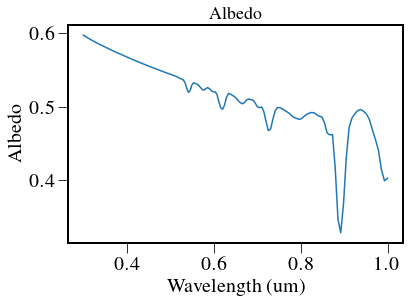

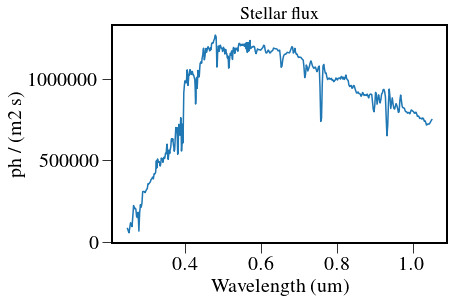

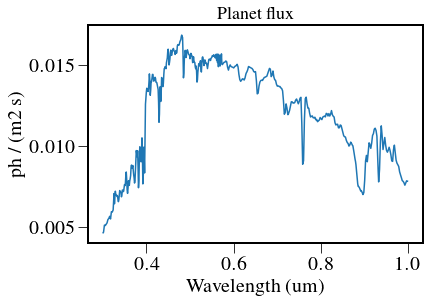

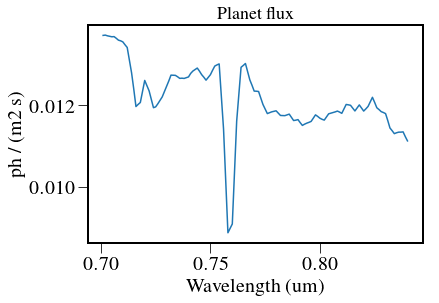

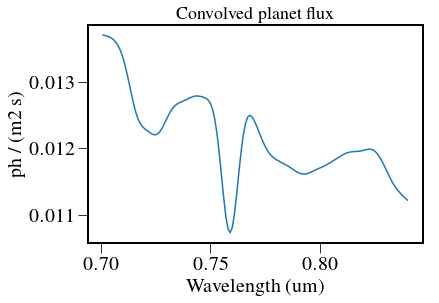

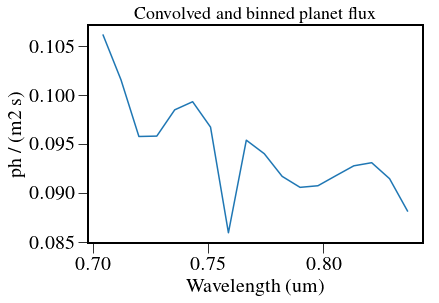

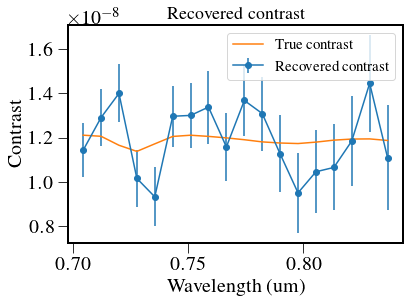

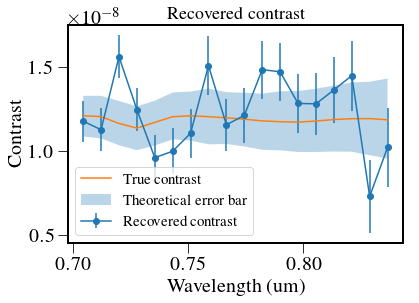

In [3]:
w, output = IFSModel(par.codeRoot+"/Inputs/LAS_spectra_for_exospec_bright_comparison_0deg_g0.0_EDC_012618_by_SRH.txt",
                     minlam=700*u.nm,
                     maxlam=841*u.nm,
                     Vmag=4.83,
                     R=50,
                     nbins=18,
                     QEfile=par.codeRoot+"/QE_CCD201.txt")
np.savetxt("/Users/mrizzo/Downloads/770.txt", output.T)
np.savetxt("/Users/mrizzo/Downloads/w770.txt", w.T)

## Band 1

FWHM is 6.72222222222 original bins
Number of IFS bins is 18
120
[ 0.60385  0.6105   0.61715  0.62385  0.6305   0.63715  0.64385  0.6505
  0.65715  0.66385  0.6705   0.67715  0.68385  0.6905   0.69715  0.70385
  0.7105   0.71715] um
Rate per pixel: [ 0.00045735  0.00045425  0.00044881  0.00044922  0.00045307  0.00045526
  0.00045323  0.00044652  0.00044018  0.00044338  0.00044442  0.00044571
  0.00044567  0.00044166  0.00043556  0.00043096  0.00042483  0.00041433] ct / s


,Wavelength,Shot noise,Detector noise,Speckle noise,Total noise,Signal,SNR
0,0.60385,43.255186,63.479887,20.045476,79.388464,1083.690801,13.650482
1,0.61050,42.993898,63.479887,19.988162,79.231925,1061.911562,13.402572
2,0.61715,42.524054,63.479887,19.676556,78.899670,1025.844629,13.001887
3,0.62385,42.557601,63.479887,19.631244,78.906471,1029.296958,13.044519
4,0.63050,42.885235,63.479887,19.734867,79.109445,1055.923145,13.347624
5,0.63715,43.073649,63.479887,19.861127,79.243294,1070.452351,13.508428
6,0.64385,42.896988,63.479887,19.689139,79.104423,1057.534965,13.368847
7,0.65050,42.305533,63.479887,19.027988,78.622633,1015.868707,12.920818
8,0.65715,41.739940,63.479887,18.430373,78.176705,976.221629,12.487372
9,0.66385,42.031627,63.479887,18.881871,78.440288,994.696959,12.680945


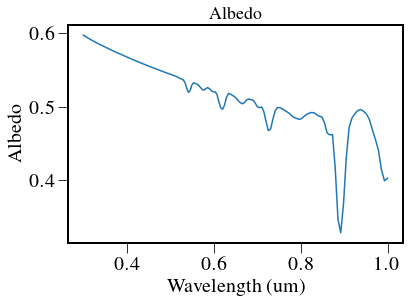

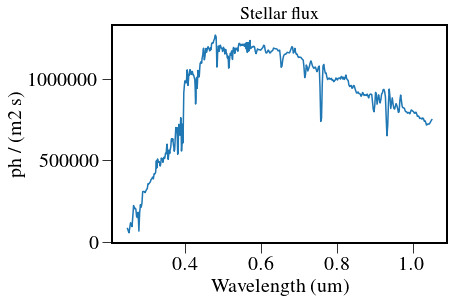

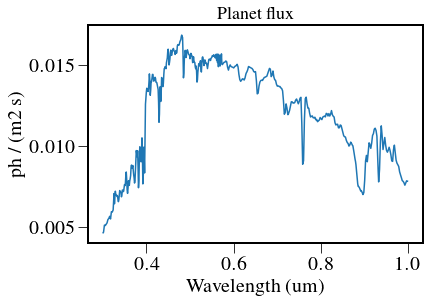

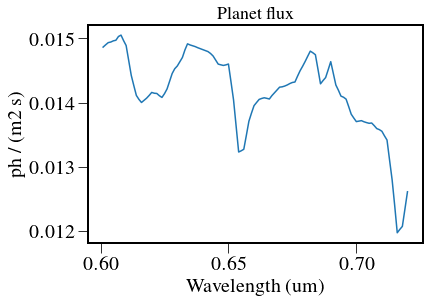

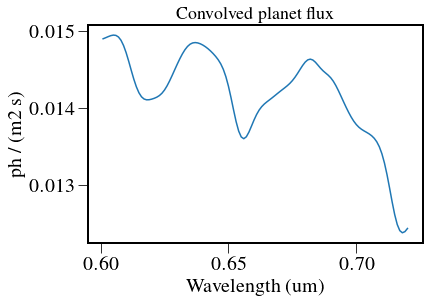

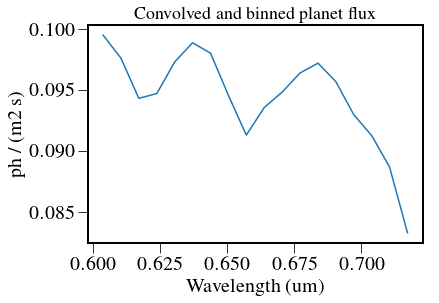

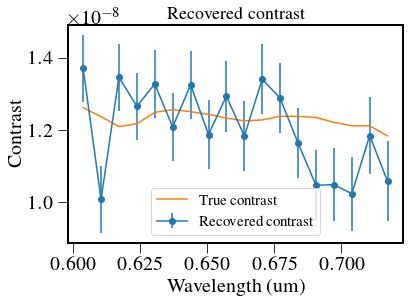

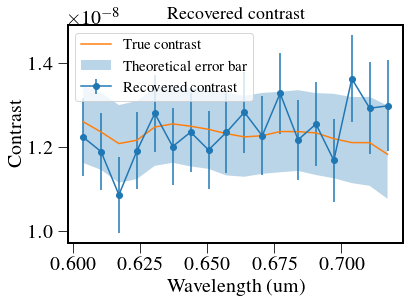

In [4]:
w, output = IFSModel(par.codeRoot+"/Inputs/LAS_spectra_for_exospec_bright_comparison_0deg_g0.0_EDC_012618_by_SRH.txt",
                     minlam=600*u.nm,
                     maxlam=721*u.nm,
                     Vmag=4.83,
                     R=50,
                     QEfile=par.codeRoot+"/QE_CCD201.txt",
                     QELosses=0.9*0.97*0.9*0.81,  # losses on top of QE
                     verbose=True,
                     cic=2e-2*u.ct,  # CIC
                     dark=2.24e-4*u.ct/u.s,  # dark current
                     zodi=1.1e-3*u.ct/u.s,  # total zodiacal contribution
                     CFcontrast=2.2e-9,
                     I_pk=1.4e-3,
                     mpix=20,  # Noise equivalent pixels
                     nbins=18,
                     # used for speckle estimates (will ask Bijan)
                     cgi_mpix=32,
                     sp_tau=0.34,  # speckle throughput
                     tau=0.0144,  # planet throughput
                     A=3.68*u.m**2,  # aperture size
                     mult=1.32,
                     fpp=0.1,
                     ftime=100*u.s,
                     obstime=100*3600*u.s,
                     forceSNR=None,  # 10,
                     ntrials=1000,)
np.savetxt("/Users/mrizzo/Downloads/660.txt", output.T)
np.savetxt("/Users/mrizzo/Downloads/w660.txt", w.T)